In [1]:
%matplotlib inline 
import numpy as np 
import pylab as pl 
from wmf import wmf
import glob
import pandas as pd 

No se logra importar deap tools, por lo tanto se deshabilita SimuBasin.Calib_NSGAII


In [2]:
#Reads the DEM and DIR maps used to extract the stream and the watershed, also their are used to obtain characteristics of the watershed.
DEM, epsg = wmf.read_map_raster('dem150.tif', isDEMorDIR=True, dxp=150, noDataP=-9999)
DIR, epsg = wmf.read_map_raster('dir150', isDEMorDIR=True, dxp = 150, isDIR=True, noDataP=-9999)

In [3]:
#Obtain a stream inside the desired watershed, it will be used to correct the coordinates of the watershed outlet.
st = wmf.Stream(572600, 4783479, DEM, DIR, epsg)

#Obtain the watershed class at its outlet
cu = wmf.SimuBasin(644635, 4732415, DEM, DIR, stream=st, umbral=10, )

#Save vector files of the watershed boundaries and network.
cu.Save_Basin2Map('cuenca.shp')
cu.Save_Net2Map('red.shp', )

#Obtain the geomorphological features of the watershed
cu.GetGeo_Parameters()

In [4]:
basin = cu

In [5]:
#Get parameters in function of the DEM
basin.GetGeo_Cell_Basics()
basin.GetGeo_HAND()
basin.GetGeo_IT()
#Stream and hills order parameters
basin.GetGeo_StreamOrder()
#Get isocrones using the concentration time from Kiprich
basin.GetGeo_Parameters()
basin.GetGeo_IsoChrones(basin.Tc['Kiprich'])

/Users/nicolas/.local/lib/python3.7/site-packages/wmf/wmf.py:1485: RuntimeWarning: invalid value encountered in true_divide
  self.CellDUNE = hand / hdnd
/Users/nicolas/.local/lib/python3.7/site-packages/wmf/wmf.py:1486: RuntimeWarning: divide by zero encountered in log
  self.CellrDUNE = -1 * np.log(self.CellDUNE)
/Users/nicolas/.local/lib/python3.7/site-packages/wmf/wmf.py:1486: RuntimeWarning: invalid value encountered in log
  self.CellrDUNE = -1 * np.log(self.CellDUNE)


## Soil properties

In [67]:
#User defined functions to process some polaris maps (http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/)

def WeigthMean(var):
    W = np.array([1/5.,1/10.,1/15.,1/30,1/50])
    Kmean = np.zeros(var.shape[1])
    for k,w in zip(var, W):
        Kmean+=k*w
    return Kmean / sum(W)
def Read_maps4depths(name):
    depths = ['0_5','5_15','15_30','30_60','60_100']
    var = []
    for d in depths:
        mapa, p, e = wmf.read_map_raster('polaris/PrMerge_'+name+'_depth_'+d+'.tif')
        k = cu.Transform_Map2Basin(mapa, p)
        var.append(k)
    return np.array(var)    

## Saturated hydraulic conductivity.

In [93]:
# Read the ksat map, convert it to the normal space (it was in the log10) and take out the outliers of the map, the plot it
ksat = Read_maps4depths('ksat')
ksat = WeigthMean(ksat)
ksat = 10**ksat
ksat = ksat * 10 / 3600. #[mm/s]
ksat[ksat > np.percentile(ksat, 97)] = np.percentile(ksat, 97)
ksat[ksat < np.percentile(ksat, 3)] = np.percentile(ksat, 3)

In [4]:
1340/60.

22.333333333333332

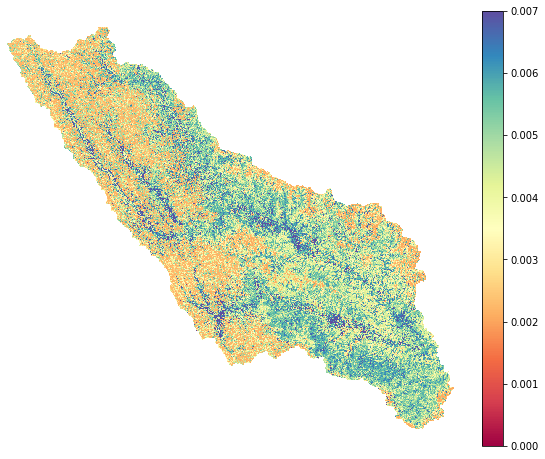

([539886.1875, 648590.6426849365, 4713953.5, 4811870.708511353],
 <matplotlib.axes._subplots.AxesSubplot at 0x2ba055b14cc0>)

In [94]:
cu.Plot_basinClean(ksat, show_cbar=True, vmin=0.0, vmax=0.007)

## Capillary and Gravitational Storage.

In [107]:
theta_r = Read_maps4depths('theta_r')
theta_r = WeigthMean(theta_r)
theta_r[theta_r> np.percentile(theta_r, 99)] =  np.percentile(theta_r, 99)
theta_r[theta_r< np.percentile(theta_r, 1)] =  np.percentile(theta_r, 1)

In [108]:
theta_s = Read_maps4depths('theta_s')
theta_s = WeigthMean(theta_s)
theta_s[theta_s> np.percentile(theta_s, 99)] =  np.percentile(theta_s, 99)
theta_s[theta_s< np.percentile(theta_s, 1)] =  np.percentile(theta_s, 1)

Setup the total storage avaiable at the capillary and gravitational storages.

In [568]:

Hg = 1000*(theta_s - 0.2) # mm
Hu = 1000*(0.2 - theta_r) # mm

cu.set_PhysicVariables('capilar',Hu,0)
cu.set_PhysicVariables('gravit',Hg,0)

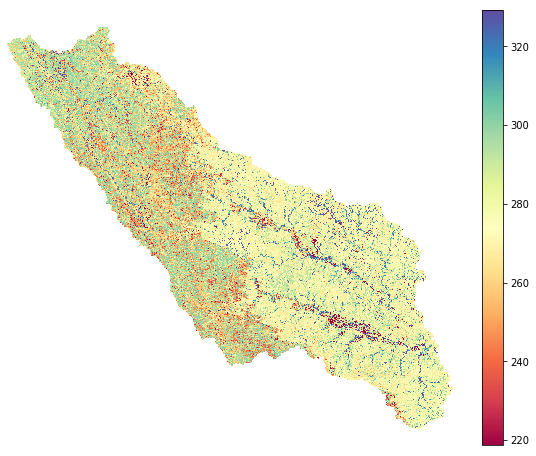

([539886.1875, 648590.6426849365, 4713953.5, 4811870.708511353],
 <matplotlib.axes._subplots.AxesSubplot at 0x2ba056337198>)

In [130]:
cu.Plot_basinClean(Hg, show_cbar=True, vmin = np.percentile(Hg, 1), vmax = np.percentile(Hg, 99))

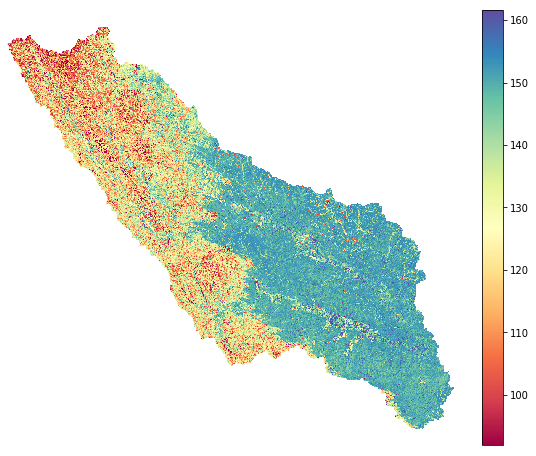

([539886.1875, 648590.6426849365, 4713953.5, 4811870.708511353],
 <matplotlib.axes._subplots.AxesSubplot at 0x2ba0563c6a20>)

In [131]:
cu.Plot_basinClean(Hu, show_cbar=True, vmin = np.percentile(Hu, 1), vmax = np.percentile(Hu, 99))

## Roughness and hillslope speed.

Land use codes:
1. Water
2. Wetland: 0.086
3. Coniferous Forest: 0.198
4. Deciduous Short: 0.36 * 0.5
5. Deciduous Medium: 0.36
6. Deciduous Tall: 0.36 * 1.5
7. Grass 1: 0.32
8. Grass 2: 0.32
9. Cut Hay: 0.024
10. Corn: 0.024
11. Soybeans: 0.024
12. Barren / Fallow: 0.0113
13. Structures: 0.04
14. Reads / Imprevius: 0.04
15. No data

Taken from: Kalyanapu el at., 2010; Manning et al., 1890.

https://www.researchgate.net/publication/291831050_SHALLOW_GROUNDWATER_MODELING_OF_THE_HISTORICAL_IRWIN_WET_PRAIRIE_IN_THE_OAK_OPENINGS_OF_NORTHWEST_OHIO/figures?lo=1


In [518]:
cover, p, e = wmf.read_map_raster('usos_merge_reproj.tif')
cover = cu.Transform_Map2Basin(cover, p)

In [538]:
roughness = {'2': 0.086,
            '3': 0.198,
            '4':0.36*0.7,
            '5':0.36,
            '6':0.36*1.3,
            '7':0.32,
            '8':0.32,
            '9':0.024,
            '10':0.024,
            '11':0.024,
            '12':0.0113,
            '13':0.04,
            '14':0.04}
manning = np.zeros(cu.ncells)
for k in roughness.keys():
    manning[cover == float(k)] = roughness[k]
manning[manning == 0] = np.percentile(manning, 50)

The original equation is defined at Velez (2001).

$V_1 = \frac{\beta}{n} A^{(2/3)e_1} S_0^{1/2}$

In this equation, according to Foster and Lane (1981) $e1$ is equal to 0.64 and $\beta$ is equal to 0.5.  For the model the equation is defined as a coefficient $C_1$ and an exponent $\lambda_1$:

- $C_1 = \frac{\beta}{n} S_0^{1/2}$

- $\lambda_1 = (2/3) \cdot e_1$

The new shape of the equation is:

$v_1 = C_1 \cdot A^{\lambda_1}$

In [548]:
#Hillslope speed coefficient C1
C1 = (0.5 * cu.CellSlope**(1/2.0)) / manning

#Exponent lambda1
L1 = (2/3.0) * 0.64

#Establece el coef y el exponente del superficial 
cu.set_PhysicVariables('h_coef', C1, 0)
cu.set_PhysicVariables('h_exp', L1, 0)

# Coloca superficial y sub-superficial como no lineal 
cu.set_Speed_type([2,2,1])

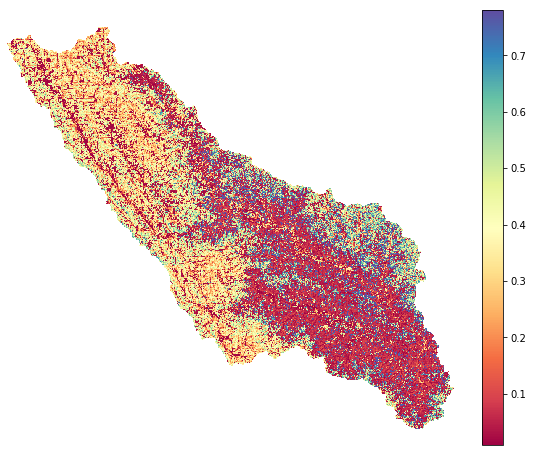

([539886.1875, 648590.6426849365, 4713953.5, 4811870.708511353],
 <matplotlib.axes._subplots.AxesSubplot at 0x2ba0554d09e8>)

In [566]:
#Speed map assuming a depth of 1 cm
v1 = C1 * (10.0/1000) ** L1
cu.Plot_basinClean(v1, show_cbar=True, vmin = np.percentile(v1, 1), vmax = np.percentile(v1, 95))

## Subsurface speed (vertical and horizontal)

The subsurfac speed is defined from the Kubota and Sivapalan eq (1995).  

$k_{h}=\frac{k_{s}S_{0} \Delta x^2}{3H_{g}^2} A ^2$

In this case the coefficient is:

- $C_2 = \frac{k_{s}S_{0} \Delta x^2}{3H_{g}^2} $
- $\lambda_2 = 2.0$

In [582]:
#Coefficient and exponent for the subsurface.
C2 = (ksat*cu.CellSlope*(150**2.0))/(3*(Hg*0.9/1000.0)**2)
L2 = 2.0

#Put the parameters into the model 
cu.set_PhysicVariables('h_coef',C2,1)
cu.set_PhysicVariables('h_exp',L2,1)
#The baseflow is the same conductivity.
cu.set_PhysicVariables('h_coef', ksat, 2)

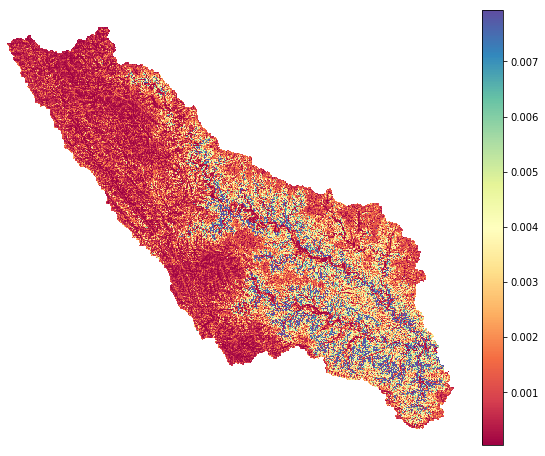

([539886.1875, 648590.6426849365, 4713953.5, 4811870.708511353],
 <matplotlib.axes._subplots.AxesSubplot at 0x2ba0893de518>)

In [581]:
#Speed map assuming a depth of 1 cm
v2 = C2 * (10/1000) ** L2
cu.Plot_basinClean(v2, show_cbar=True, vmin = np.percentile(v2, 1), vmax = np.percentile(v2, 95))

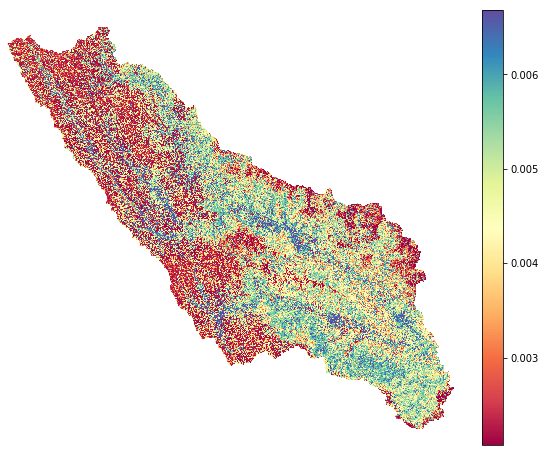

([539886.1875, 648590.6426849365, 4713953.5, 4811870.708511353],
 <matplotlib.axes._subplots.AxesSubplot at 0x2ba08922ed30>)

In [578]:
#Baseflow Speed map assuming a depth of 1 cm
cu.Plot_basinClean(ksat, show_cbar=True, vmin = np.percentile(ksat, 1), vmax = np.percentile(ksat, 95))

## Vertical flows

In [588]:
# Evaporation rate
cu.GetGeo_Cell_Basics()
#Evp=4.658*np.exp(-0.0002*cu.CellHeight)/288.0
# St parameters into the model 
List=[1.0,ksat,ksat/10.,0.0]
for pos,var in enumerate(List):
    cu.set_PhysicVariables('v_coef',var,pos)

## Channel parameters 

In [633]:
#Obtain the area of the cells and then, the OGC parameters.
area = wmf.cu.basin_acum_var(cu.structure[0], np.ones((1,cu.ncells))*(150**2)/1e6, cu.ncells)[0]
C3,L3 = wmf.OCG_param(pend = cu.CellSlope, area = area)

#Aggregate the OCG coefficient by channel links.
C3_link = cu.Transform_Basin2Hills(C3, mask=cu.CellCauce)
C3_link = cu.Transform_Hills2Basin(C3_link)

#Set the parameters into the model.
cu.set_PhysicVariables('h_coef',C3_link,3)
#Variable del exponente horizontal 
cu.set_PhysicVariables('h_exp',L3,3)

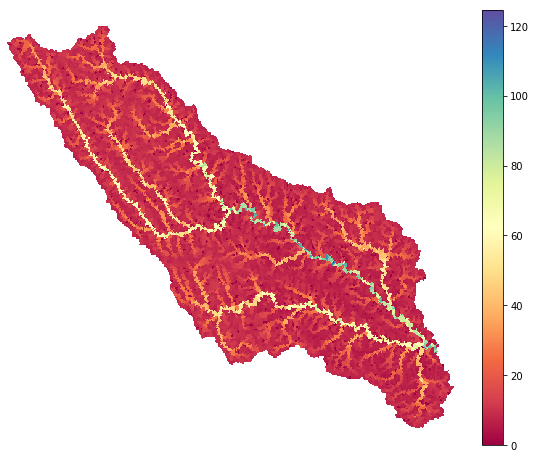

([539886.1875, 648590.6426849365, 4713953.5, 4811870.708511353],
 <matplotlib.axes._subplots.AxesSubplot at 0x2ba08a47df98>)

In [684]:
cu.Plot_basinClean(C3_link, show_cbar=True)

## Channels width setup in function of the lidar images 

In [685]:
widths = pd.read_excel('channel_width.xlsx')

In [686]:
area_hill = cu.Transform_Basin2Hills(area, SumMeanMax=2)

In [697]:
# compare the widths with the area
areas_widths = []
for i in widths['Link']:
    p = np.where(cu.hills_own == i)[0]
    areas_widths.append(area[p].max())
widths['area'] = areas_widths
#fit 
x = np.log(widths['area'])
y = np.log(widths['width'])
fit = np.polyfit(x, y, 1)
width_func = lambda x: np.exp(fit[1]) * x ** fit[0]
width_sim = list(map(width_func, np.linspace(10, 4000)))

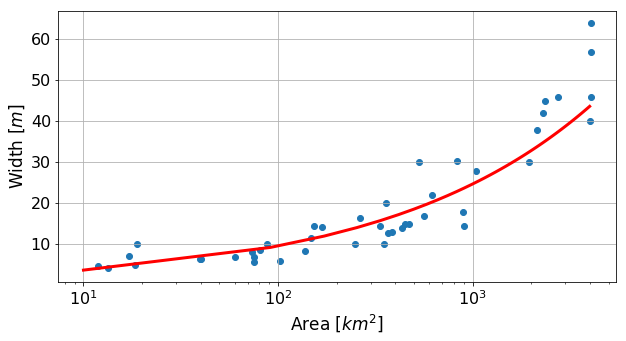

In [705]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
pl.scatter(widths['area'], widths['width'])
pl.plot(np.linspace(10, 4000), width_sim, 'r', lw = 3)
ax.tick_params(labelsize = 16)
pl.xscale('log')
ax.set_xlabel('Area [$km^2$]', size = 17)
ax.set_ylabel('Width [$m$]', size = 17)
ax.grid()

In [707]:
width_map = np.array(list(map(width_func, area)))
width_map_hills = cu.Transform_Basin2Hills(width_map, SumMeanMax=0, mask=cu.CellCauce)
width_map_t = cu.Transform_Hills2Basin(width_map_hills)
cu.Plot_basinClean(width_map_t, show_cbar=True)

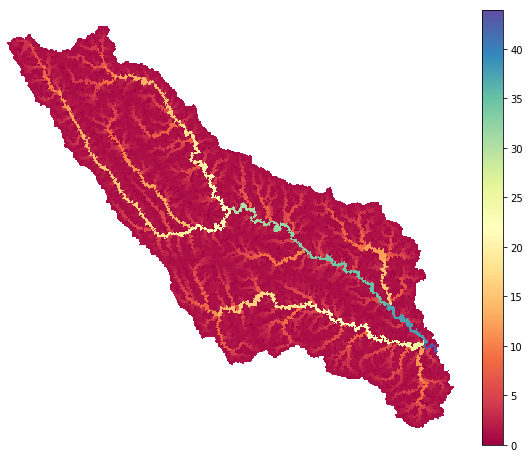

([539886.1875, 648590.6426849365, 4713953.5, 4811870.708511353],
 <matplotlib.axes._subplots.AxesSubplot at 0x2ba08ad538d0>)

In [712]:
cu.set_Geomorphology([2, 10], stream_width=width_map_t)

In [723]:
wmf.models.stream_long = np.ones((1, cu.ncells)) * cu.CellLong

In [726]:
cu.Save_SimuBasin('TurkeyBasin_simSetup.nc')

# Develop of a novel tool for basin plot

In [2]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature


In [48]:
reader = shpreader.Reader('red.shp')

In [8]:
basin = wmf.SimuBasin(rute='turkeyBasin150.nc')

In [24]:
def graficar_cuenca(vector_cuenca = None, ax = None, 
    figsize = (10, 10), ruta_guardar = None, dpi = 100, 
    cmap = 'viridis', title_size = 24, titulo = '', 
    titulo_colorbar = '', norm  = None, levels = None,color_perimetro = 'r',
    shape_path = None, shape_color = 'blue', shape_width = 0.5,
    cbar_title = '', cbar_loc = [0.4, 0.8, 0.4, 0.03], cbar_ticks = None, cbar_ticklabels = None,
    cbar_ticksize = 16, cbar_orientation = 'horizontal'):
    
    #Pretty colorbar
    if norm != None:
        cmap = matplotlib.colors.ListedColormap(cmap(np.arange(256))[::len(norm)])
        norm = matplotlib.colors.BoundaryNorm(norm, cmap.N)
    #Get the projection from the watershed project.
    proj = ccrs.epsg(basin.epsg)
    #Define the aces if not given
    if ax == None:
        fig = pl.figure(figsize = figsize)
        ax = fig.add_subplot(1, 1, 1, projection = proj) 
    
    #title
    t = ax.set_title(titulo, fontsize = title_size)
    t.set_y(1.05)
    #If there is a raster map to plot
    if vector_cuenca is not None:
        mapa, prop = basin.Transform_Basin2Map(vector_cuenca)
        celdas_x, celdas_y, coordenada_x_abajo_izquierda, coordenada_y_abajo_izquierda, delta_x, delta_y, nodata = prop
        mapa[mapa == nodata] = np.nan
        longitudes = coordenada_x_abajo_izquierda + delta_x * np.arange(celdas_x)
        latitudes = coordenada_y_abajo_izquierda + delta_y * np.arange(celdas_y)
        longitudes, latitudes = np.meshgrid(longitudes, latitudes)
        cs = ax.contourf(longitudes, latitudes, mapa.T[::-1], transform = proj, cmap = cmap, levels = levels, norm = norm)
        cax = fig.add_axes(cbar_loc)
        cbar = pl.colorbar(cs, cax = cax, orientation=cbar_orientation)
        cbar.ax.tick_params(labelsize = cbar_ticksize)
        cbar.ax.set_title(cbar_title, size = 16)
    #Watershed divisory
    ax.plot(basin.Polygon[0], basin.Polygon[1], color = color_perimetro)
    ax.outline_patch.set_visible(False)
    #Qny shape to show.
    if shape_path is not None:
        shape_feature = ShapelyFeature(Reader(shape_path).geometries(),
                                proj, edgecolor='blue', )
        ax.add_feature(shape_feature, facecolor=shape_color,linewidth=shape_width)
    return cbar

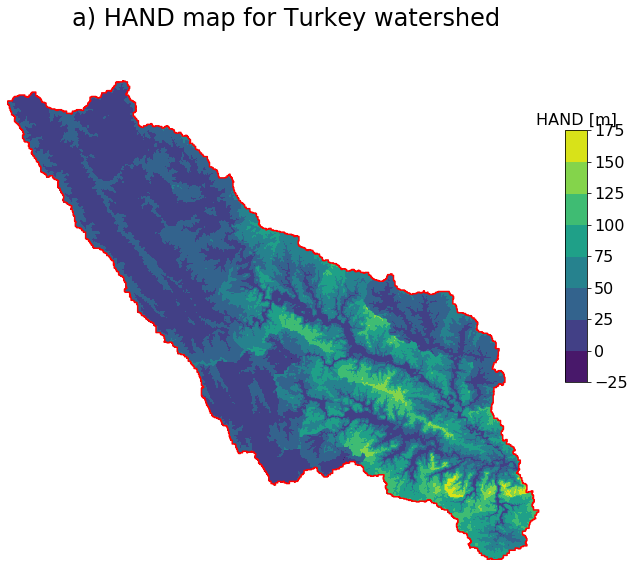

In [27]:
cbar= graficar_cuenca(cu.CellHAND,titulo='a) HAND map for Turkey watershed', cbar_title='HAND [m]', 
    cbar_loc=[0.9, 0.4, 0.03, 0.35], cbar_orientation = 'vertical')

In [42]:
cbar.ax.tick_params(labelsize = 17)

In [ ]:
cbar.set_ticks